# <img src="https://upload.wikimedia.org/wikipedia/commons/6/60/NISAR_artist_concept.jpg" width=400 align="left"/><br><br><br><br>



<img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/NISAR_Mission_Logo.png" width=400 align="left"/><br><br><br><br><br>



# Classification of Wetland Inundation Extent
Bruce Chapman, Paul Siqueira
February 15, 2022

First, the images of the multi-temporal sequence must be well radiometrically calibrated relative to each other, to a higher precision than perhaps required through routine standard calibration of the NISAR imagery. This optional calibration step examines distributed targets that are expected to be unchanged or minimally changed in brightness over a set time span of  an image sequence. With NISAR’s 240 km swath width, it is reasonably assumed that a statistically large area, A<sub>ni</sub>, will not be inundated (or otherwise changing) during any of the 2n observations surrounding the image to be calibrated and classified. These areas will be identified through use of a priori wetlands mask and partly through image segmentation or other methods over the 2n images. <br>
A set of classes will be identified from a multitemporal average of a subset of images including:

1.	Inundated vegetation (presumption: dominated by double bounce scatter in HH channel) 
2.	Open water (presumption: low specular scattering in both channels)
3.	Not inundated (presumption: brighter specular scatter, volume scattering)
4.	Not classified (presumption: pixels do not align with the scattering model, or no data)

These classes are selected based on calibrated threshold values for the radar backscatter and other metrics. In addition, this same multi-temporal image sequence allows the algorithm to include a more sensitive change detection component for improved robustness. Change detection will allow for refinement within the multitemporal image sequence for change of class during the image sequence that may be more robust than simply classifying the image backscatter and backscatter ratio values.  

Still to be implemented in notebook form:  

&nbsp;&nbsp;&nbsp;Incorporating datatakes from both ascending and descending orbits with varying incidence angles<br>
&nbsp;&nbsp;&nbsp;Incorporating datatakes that only have HH channel (no HV)<br>
&nbsp;&nbsp;&nbsp;Aggregating results to 1 ha<br>
&nbsp;&nbsp;&nbsp;Evalation against reference data set<br>
&nbsp;&nbsp;&nbsp;Calibration of thresholds with reference data set<br>



# Below are the modules that must be available for import:

In [1]:
import os
import glob
import rasterio
import struct
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import warnings
from matplotlib import colors
from rasterio.plot import show_hist
import re
import datetime
from scipy import signal

# Find and ingest NISAR simulated imagery of Yucatan Lake, LA area

This data was collected 2019 by UAVSAR, and subsequently degraded to expected NISAR characteristics.  

Two simulated bands were created, one with a bandwidth of 20 Mhz (band A), and another with a bandwidth of 5 Mhz (band B).  Either band may be used to create independent estimates of inundation extent or may be multilooked together to decrease speckle.

For this example, only data collections from the same heading were selected.

During the observed time period, Yucatan Lake and the nearby Mississippi River went from  historically high water levels to seasonally expected lower water levels (but still above flood stage in some places).

In [2]:
#set up
main_dir = os.getcwd()
SAR_data_dir = os.path.join(main_dir,'SAR_data')
Output_folder = os.path.join(main_dir,'Notebook_outputs')

if(not os.path.isdir(Output_folder)):
    os.mkdir(Output_folder)
#number of lines and samples    
nsamp = 1604
nline = 1850

#find files, both band A and band B, but currently only using band A
SAR_HH_images = glob.glob(os.path.join(SAR_data_dir,'*/*_HHHH_*129A_*.flt'))
SAR_HV_images = glob.glob(os.path.join(SAR_data_dir,'*/*_HVHV_*129A_*.flt'))
SAR_HH_images_B = glob.glob(os.path.join(SAR_data_dir,'*/*_HHHH_*129B_*.flt'))
SAR_HV_images_B = glob.glob(os.path.join(SAR_data_dir,'*/*_HVHV_*129B_*.flt'))

#get dates
date_array = []
for fname in SAR_HH_images:
    basename = os.path.basename(fname)
    datestr = re.findall("_(\d\d\d\d\d\d)_",basename)
    year = (2000+int(datestr[0][0:2]))
    month = int(datestr[0][2:4])
    day = int(datestr[0][4:6])
    date_array = np.append(date_array,datetime.date(year,month,day))

indices = np.argsort(date_array)   # returns the indices so that the dates are sorted

SAR_HH_images = [SAR_HH_images[ii] for ii in indices]
SAR_HV_images = [SAR_HV_images[ii] for ii in indices]
SAR_HH_images_B = [SAR_HH_images_B[ii] for ii in indices]
SAR_HV_images_B = [SAR_HV_images_B[ii] for ii in indices]
date_array = date_array[indices]

num=indices[0]
print("Dates of observation (HH and HV):")
for ii in range(0,len(indices)):
    print(date_array[ii])


Dates of observation (HH and HV):
2019-07-01
2019-07-16
2019-07-25
2019-08-12
2019-09-23
2019-09-30


# Water Level from nearby USGS water level gage with above image acquisition dates, showing 30 feet change in water level during the course of those acquisitions.

<img style="float: left;" src="water_level_chart.png">

https://rivergages.mvr.usace.army.mil/WaterControl/stationinfo2.cfm?sid=CE40FF58&fid=VCKM6&dt=S

# Read in imagery, with option to combine with band B

In [3]:
#read data
mask = np.ones((nline,nsamp)) 
# Read raster files and make them into a 3D numpy array
#band A
rasterstack = []
for image in SAR_HH_images:
    fid = open(image,'rb')
    btemp = fid.read()    # temporary binary file
    fid.close;
    ftemp = np.array(struct.unpack('f'*int(len(btemp)/4),btemp)).reshape((nline,nsamp))
    ftemp = np.clip(ftemp,0.0,10000.0)   # limit values between zero and 10,000 (a very large number)
    mask = np.multiply(mask,ftemp>0)     # any value with a zero in it becomes part of the mask
    rasterstack.append(ftemp)
rasterstack_HH = np.array(rasterstack, dtype=float)

rasterstack = []
for image in SAR_HV_images:
    fid = open(image,'rb')
    btemp = fid.read()    # temporary binary file
    fid.close;
    ftemp = np.array(struct.unpack('f'*int(len(btemp)/4),btemp)).reshape((nline,nsamp))
    ftemp = np.clip(ftemp,0.0,10000.0)
    mask = np.multiply(mask,ftemp>0)
    rasterstack.append(ftemp)
rasterstack_HV = np.array(rasterstack, dtype=float)

#band B
rasterstack = []
for image in SAR_HH_images_B:
    fid = open(image,'rb')
    btemp = fid.read()    # temporary binary file
    fid.close;
    ftemp = np.array(struct.unpack('f'*int(len(btemp)/4),btemp)).reshape((nline,nsamp))
    ftemp = np.clip(ftemp,0.0,10000.0)
    mask = np.multiply(mask,ftemp>0)
    rasterstack.append(ftemp)
rasterstack_HH_B = np.array(rasterstack, dtype=float)

rasterstack = []
for image in SAR_HV_images_B:
    fid = open(image,'rb')
    btemp = fid.read()    # temporary binary file
    fid.close;
    ftemp = np.array(struct.unpack('f'*int(len(btemp)/4),btemp)).reshape((nline,nsamp))
    ftemp = np.clip(ftemp,0.0,10000.0)
    mask = np.multiply(mask,ftemp>0)
    rasterstack.append(ftemp)
rasterstack_HV_B = np.array(rasterstack, dtype=float)

#option: combine band A and band B by multilooking
#for some reason, band B is in the opposite order
for ii in range(len(rasterstack_HH)):
    rasterstack_HH[ii,:,:]=(rasterstack_HH[ii,:,:]+rasterstack_HH_B[num-ii,:,:])/2.0
    rasterstack_HV[ii,:,:]=(rasterstack_HV[ii,:,:]+rasterstack_HV_B[num-ii,:,:])/2.0
    
#option: Classify band B
#for some reason, band B is in the opposite order
#for ii in range(len(rasterstack_HH)):
#    rasterstack_HH[ii,:,:]=rasterstack_HH_B[num-ii,:,:]
#    rasterstack_HV[ii,:,:]=rasterstack_HV_B[num-ii,:,:]
    
ss=np.zeros(3,dtype=np.int16)
ss[0]=int(rasterstack_HV.shape[0])
ss[1]=int(rasterstack_HV.shape[1])
ss[2]=int(rasterstack_HV.shape[2])


# Option: spatial rolling average 

In [4]:
#5x5
#ispat=0 - no spatial averaging
#ispat=1 - execute spatial averaging comparable to output pixel spacing (ie about 5x5)
#  -- but UAVSAR pixel spacing is just 6 m, so this correponds to an output pixel spacing of 30 m.
ispat=1
if ispat == 1:
    ks = 5
    kernel=(ks,ks)
    kernel = np.ones(kernel) /(ks*ks)
    for kk in range(ss[0]):
        rasterstack_HH[kk,:,:] = signal.convolve2d(rasterstack_HH[kk,:,:], kernel, mode='same')
        rasterstack_HV[kk,:,:] = signal.convolve2d(rasterstack_HV[kk,:,:], kernel, mode='same')
 

# Option: temporal rolling average of a short time sequence of imagery

In [5]:
#if temporal rolling average is not desired, set Nave_rolling =1 below
#number of images in temporal rolling average
Nave_rolling = 2

np.seterr(divide='ignore')  # python doesn't like dividing zero by zero, NaN by NaN, etc.
np.seterr(invalid='ignore')

ss = rasterstack_HH.shape
#number of rolling averages
Nimages = ss[0]- Nave_rolling + 1
output_stack_dim = (Nimages,ss[1],ss[2])   # standard size of output rasterstack

# define arrays, filled with zeros
rasterstack_rolling_HH = np.zeros(output_stack_dim)

#if dual pol data. Otherwise, will have to just use HH for classification.

rasterstack_rolling_HV = np.zeros(output_stack_dim)
rasterstack_rolling_ratio = np.zeros(output_stack_dim)
#options:  product of HH and HV, or Sum of HH and HV
#here, using product.
rasterstack_rolling_prod = np.zeros(output_stack_dim)

for ii in range(len(rasterstack_HH)):

    for jj in range(-Nave_rolling+1,1):  # example:  -1 to 1
        kk = ii + jj
        if(kk>=0 and kk<Nimages):
            # print(ii,jj,kk)   # ii - input image, kk - output image
            # note that the rolling average for image 0 contains images 0, 1, etc., up until the number of averages,
            #      but no earlier than image 0
            rasterstack_rolling_HH[kk,:,:] = rasterstack_rolling_HH[kk,:,:]+rasterstack_HH[ii,:,:]
            rasterstack_rolling_HV[kk,:,:] = rasterstack_rolling_HV[kk,:,:]+rasterstack_HV[ii,:,:]
            rasterstack_rolling_ratio[kk,:,:] = np.divide(rasterstack_rolling_HH[kk,:,:],rasterstack_rolling_HV[kk,:,:])+np.divide(rasterstack_HH[ii,:,:],rasterstack_HV[ii,:,:])
            rasterstack_rolling_prod[kk,:,:] = np.multiply(rasterstack_rolling_HH[kk,:,:],rasterstack_rolling_HV[kk,:,:])+np.multiply(rasterstack_HH[ii,:,:],rasterstack_HV[ii,:,:])

rasterstack_rolling_HH[:,:,:]=rasterstack_rolling_HH[:,:,:]/Nave_rolling
rasterstack_rolling_HV[:,:,:]=rasterstack_rolling_HV[:,:,:]/Nave_rolling
rasterstack_rolling_ratio[:,:,:]=rasterstack_rolling_ratio[:,:,:]/Nave_rolling
rasterstack_rolling_prod[:,:,:]=rasterstack_rolling_prod[:,:,:]/Nave_rolling


# Option: calculate correction factors to insure images are relatively calibrated to one another overall

<bold>TODO: optionally select region to calculate normalization factor</bold>

In [6]:
#assumes minor over brightness fluctuations
#could be refined to not include veg. inundated areas or areas that are changing significantly
#could apply HV correction factor to HH and HV (not affected by inundation, assume similar trends)
#the original input arrays are not calibrated

#To do:  implement method to apply to image subset only, using a shapefile or pixel coordinates

np.seterr(invalid='ignore')

# options for normalization:
# ical=0 - don't normalize
# ical=1 normalize both HH and HV by HV correction factor
# ical=2 - normalize each channel separately and individually
ical=1

#define arrays
rasterstack_rolling_corrected_HH = np.zeros(output_stack_dim)
rasterstack_rolling_corrected_HV = np.zeros(output_stack_dim)
rasterstack_rolling_corrected_ratio = np.zeros(rasterstack_rolling_corrected_HH.shape)
rasterstack_rolling_corrected_product = np.zeros(rasterstack_rolling_corrected_HH.shape)

#zeros masked out previously
mean_HH = np.nanmean(rasterstack_HH)
mean_HV = np.nanmean(rasterstack_HV)

#print(mean_HH)
#print(mean_HV)

correction_factor_HH = np.zeros(Nimages)
correction_factor_HV = np.zeros(Nimages)
print("Correction factors for each image:")
print(" ")

print('  #    HHfac    HVfac')
print(' ---   -----    -----')
for ii in range(len(rasterstack_rolling_HH)):
    correction_factor_HH[ii] = np.nanmean(rasterstack_rolling_HH[ii,:,:])/mean_HH
    correction_factor_HV[ii] = np.nanmean(rasterstack_rolling_HV[ii,:,:])/mean_HV
    if ical == 0:
        correction_factor_HH[ii]=1.
        correction_factor_HV[ii]=1.
    if ical == 1:
        correction_factor_HV[ii]=np.nanmean(rasterstack_rolling_HV[ii,:,:])/mean_HV
        correction_factor_HH[ii]=correction_factor_HV[ii]
    if ical == 2:
        correction_factor_HV[ii]=np.nanmean(rasterstack_rolling_HV[ii,:,:])/mean_HV
        correction_factor_HH[ii]=np.nanmean(rasterstack_rolling_HH[ii,:,:])/mean_HH

    print('%3d   %6.3f   %6.3f' % ( ii, correction_factor_HH[ii], correction_factor_HV[ii]) )
    
for kk in range(Nimages):
    rasterstack_rolling_corrected_HH[kk,:,:] = rasterstack_rolling_HH[kk,:,:]/correction_factor_HH[kk]
    rasterstack_rolling_corrected_HV[kk,:,:] = rasterstack_rolling_HV[kk,:,:]/correction_factor_HV[kk]
    rasterstack_rolling_corrected_ratio[kk,:,:]=rasterstack_rolling_corrected_HH[kk,:,:]/rasterstack_rolling_corrected_HV[kk,:,:]
    rasterstack_rolling_corrected_product[kk,:,:]=rasterstack_rolling_corrected_HH[kk,:,:]*rasterstack_rolling_corrected_HV[kk,:,:]  

#remove NaNs
rasterstack_rolling_corrected_ratio=np.nan_to_num(rasterstack_rolling_corrected_ratio)

Correction factors for each image:
 
  #    HHfac    HVfac
 ---   -----    -----
  0    1.041    1.041
  1    1.160    1.160
  2    1.047    1.047
  3    0.993    0.993
  4    0.912    0.912


# Display corrected rolling averages, channel ratios and products

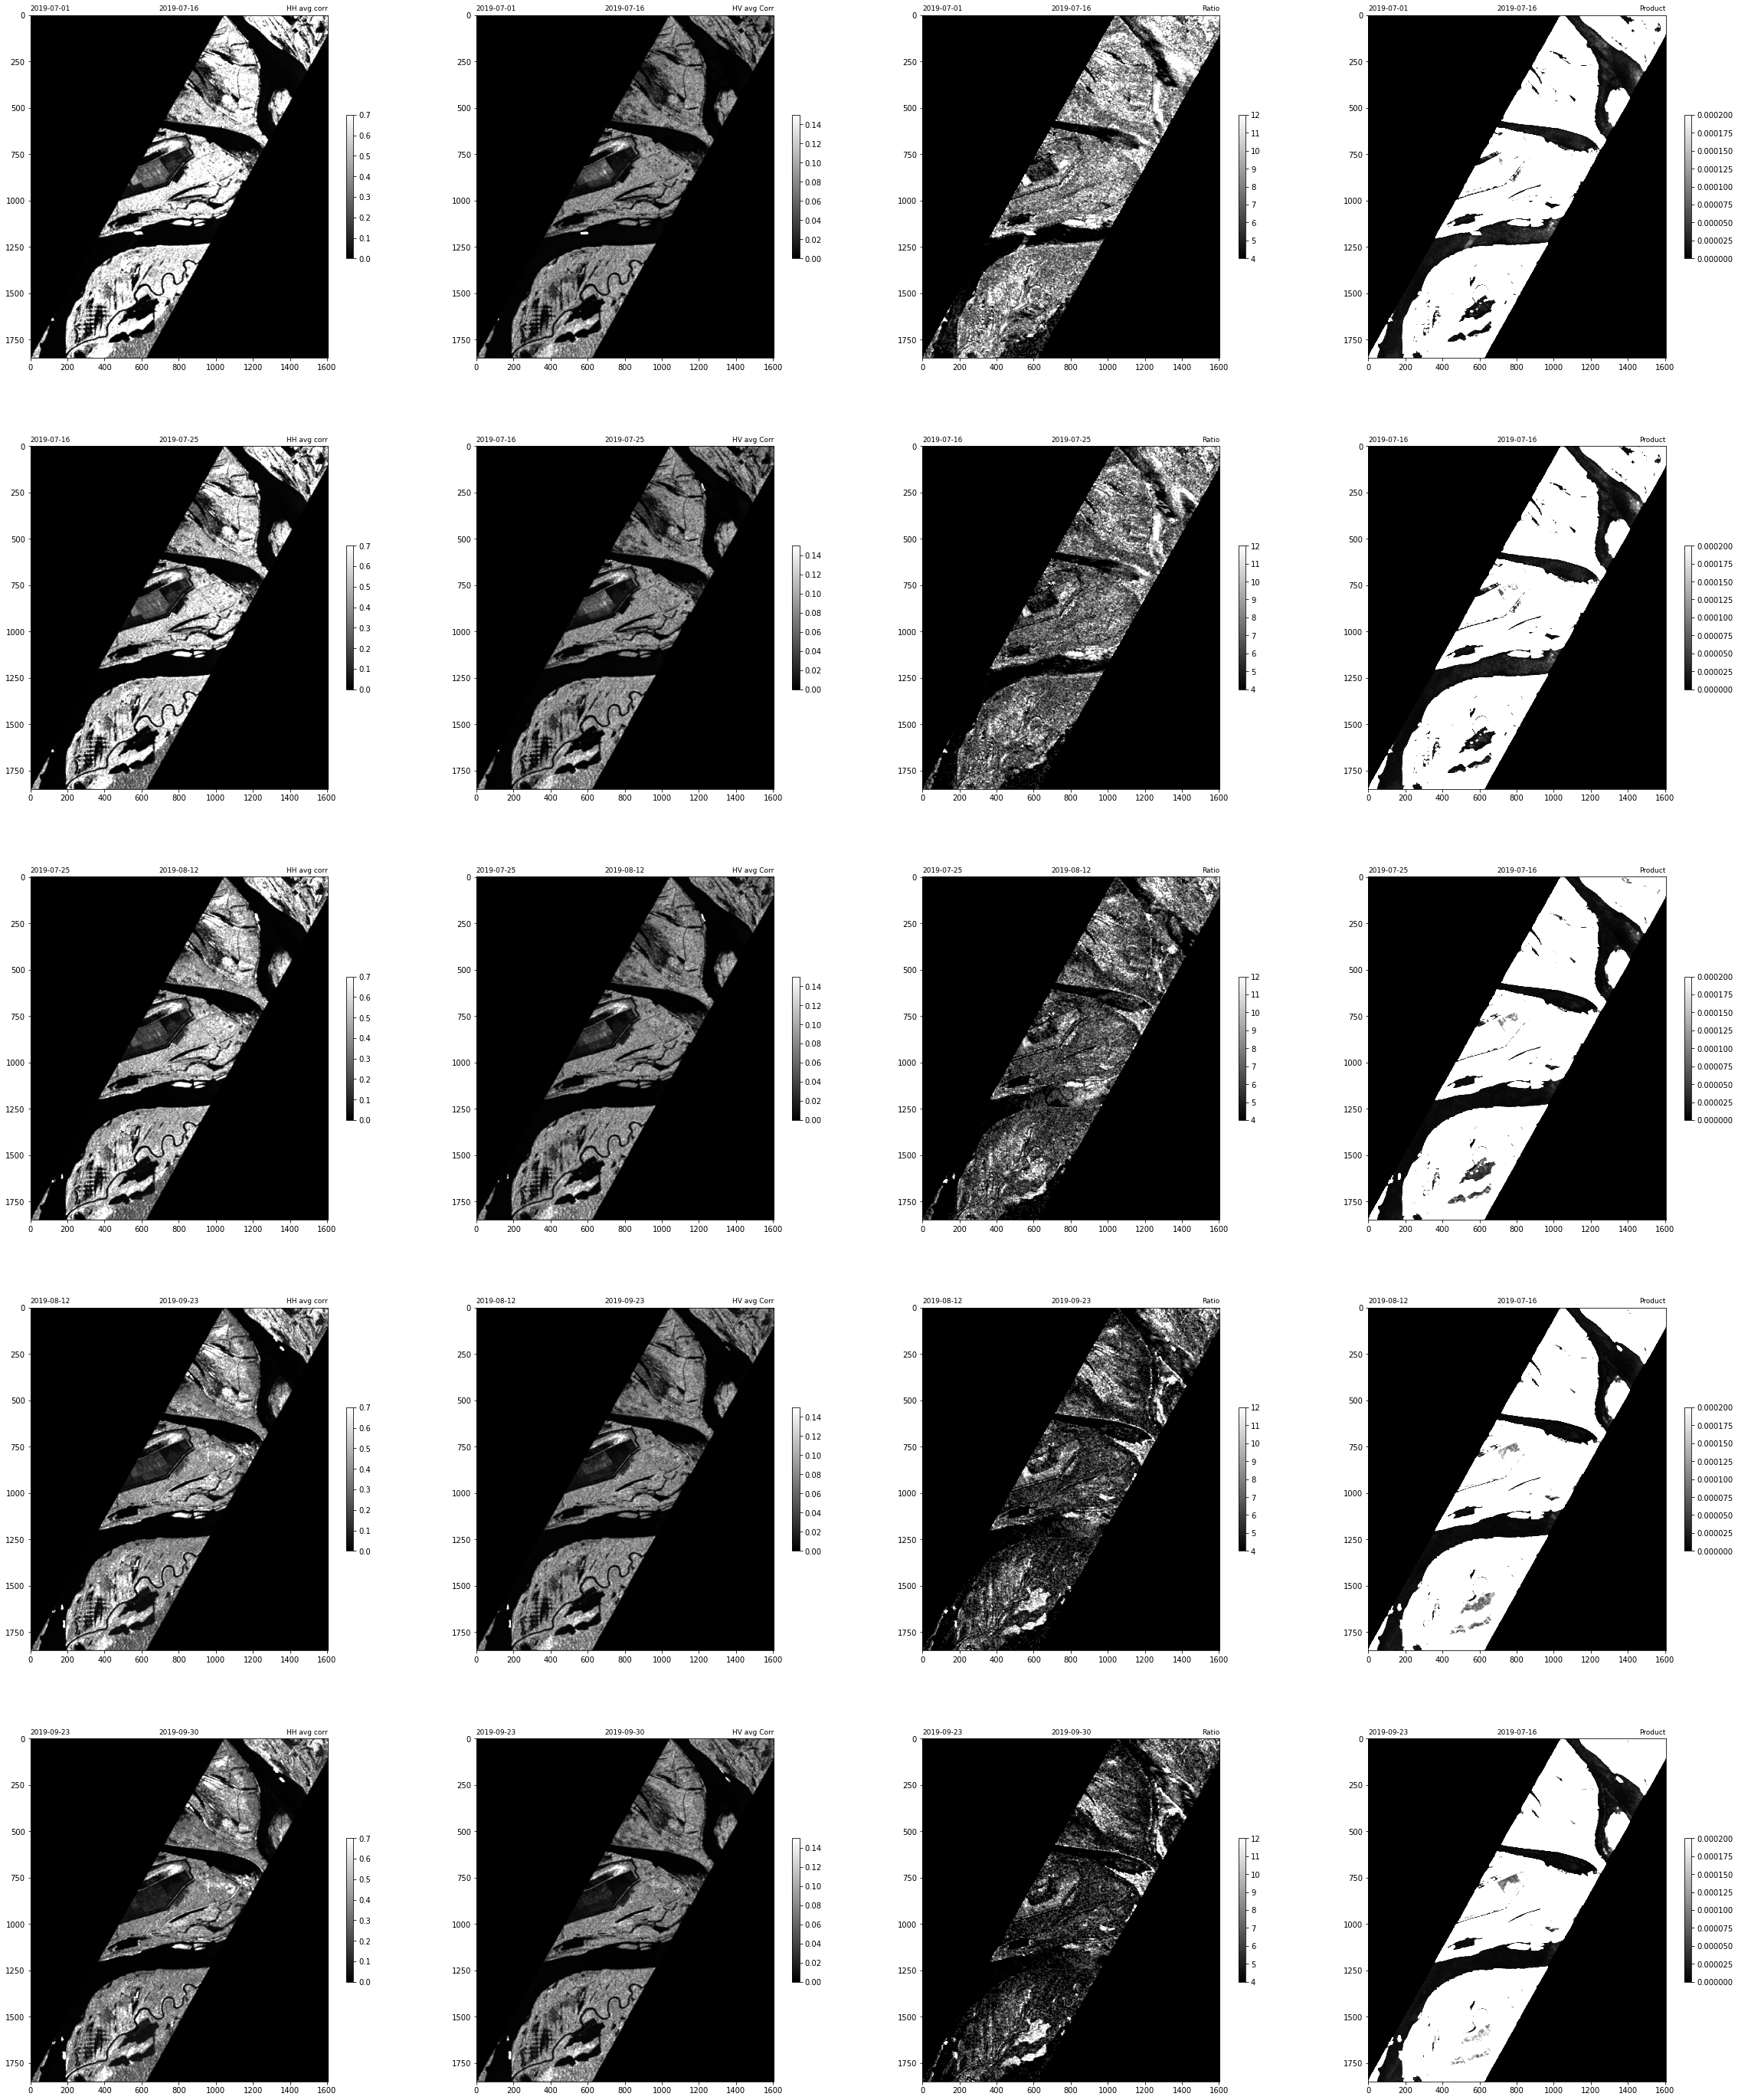

In [7]:
plt.rcParams['figure.figsize'] = (40,50)
for ii in range(Nimages):

    plt.subplot(Nimages,4,ii*4+1)
    plt.imshow(rasterstack_rolling_corrected_HH[ii,:,:],vmin=0.0,vmax=0.7,cmap=plt.cm.gray)
    plt.title(date_array[ii], loc="left",fontdict = {'fontsize' : 9})
    plt.title(date_array[ii+Nave_rolling-1], loc="center",fontdict = {'fontsize' : 9})
    plt.title("HH avg corr", loc="right",fontdict = {'fontsize' : 9})
    plt.colorbar(shrink=0.4)
    plt.subplot(Nimages,4,ii*4+2)
    plt.imshow(rasterstack_rolling_corrected_HV[ii,:,:],vmin=0.0,vmax=0.15,cmap=plt.cm.gray)
    plt.title(date_array[ii], loc="left",fontdict = {'fontsize' : 9})
    plt.title(date_array[ii+Nave_rolling-1], loc="center",fontdict = {'fontsize' : 9})
    plt.title("HV avg Corr", loc="right",fontdict = {'fontsize' : 9})
    plt.colorbar(shrink=0.4)
    plt.subplot(Nimages,4,ii*4+3)
    plt.imshow(rasterstack_rolling_corrected_ratio[ii,:,:],vmin=4,vmax=12,cmap=plt.cm.gray)
    plt.title(date_array[ii], loc="left",fontdict = {'fontsize' : 9})
    plt.title(date_array[ii+Nave_rolling-1], loc="center",fontdict = {'fontsize' : 9})
    plt.title("Ratio", loc="right",fontdict = {'fontsize' : 9})
    plt.colorbar(shrink=0.4)
    plt.subplot(Nimages,4,ii*4+4)
    plt.imshow(rasterstack_rolling_corrected_product[ii,:,:],vmin=0,vmax=.0002,cmap=plt.cm.gray)
    plt.title(date_array[ii], loc="left",fontdict = {'fontsize' : 9})
    plt.title(date_array[Nave_rolling-1], loc="center",fontdict = {'fontsize' : 9})
    plt.title("Product", loc="right",fontdict = {'fontsize' : 9})
    plt.colorbar(shrink=0.4)

# Calculate the mean for each stack of images, and the change from the mean for each time period

In [8]:
#Still to be implemented:  change relative to prior image

change_HH = np.zeros(output_stack_dim)
change_HV = np.zeros(output_stack_dim)
change_ratio = np.zeros(output_stack_dim)
change_product = np.zeros(output_stack_dim)

rasterstack_HH=np.nan_to_num(rasterstack_HH)
rasterstack_HV=np.nan_to_num(rasterstack_HV)

#check if nans are present
array_sum = np. sum(rasterstack_HH)
array_has_nan = np. isnan(array_sum)
print('Are there any NaNs in HH?', array_has_nan)
array_sum = np. sum(rasterstack_HV)
array_has_nan = np. isnan(array_sum)
print('Are there any NaNs in HV?', array_has_nan)


#disable warning: all numbers in stack at one pixel are zero -> causes warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    mean_stack_HH = np.mean(rasterstack_HH, axis=0,where=np.greater(rasterstack_HH,0.))
    mean_stack_HV = np.mean(rasterstack_HV, axis=0,where=np.greater(rasterstack_HV,0.))
    
mean_stack_HH=np.nan_to_num(mean_stack_HH)
mean_stack_HV=np.nan_to_num(mean_stack_HV)
      
mean_stack_HH=np.nan_to_num(mean_stack_HH)
mean_stack_HV=np.nan_to_num(mean_stack_HV)

output_dim = (ss[1],ss[2])  # standard size of output rasterstack

# define arrays, filled with zeros
mean_prod = np.zeros(output_dim)
mean_ratio = np.zeros(output_dim)

mean_prod[:,:]=(mean_stack_HH[:,:]*mean_stack_HV[:,:])
mean_ratio=mean_stack_HH[:,:]/mean_stack_HV[:,:]

for kk in range(Nimages):
#relative to mean
    change_HH[kk,:,:]=rasterstack_rolling_corrected_HH[kk,:,:]/mean_stack_HH
    change_HV[kk,:,:]=rasterstack_rolling_corrected_HV[kk,:,:]/mean_stack_HV
    change_ratio[kk,:,:]=rasterstack_rolling_corrected_ratio[kk,:,:]/mean_ratio
    change_product[kk,:,:]=rasterstack_rolling_corrected_product[kk,:,:]/mean_prod

change_HH=np.nan_to_num(change_HH)
change_HV=np.nan_to_num(change_HV)
change_ratio=np.nan_to_num(change_ratio)
change_product=np.nan_to_num(change_product)

Are there any NaNs in HH? False
Are there any NaNs in HV? False


# Display change over time of corrected rolling averages, channel ratios and products

Change relative to mean values


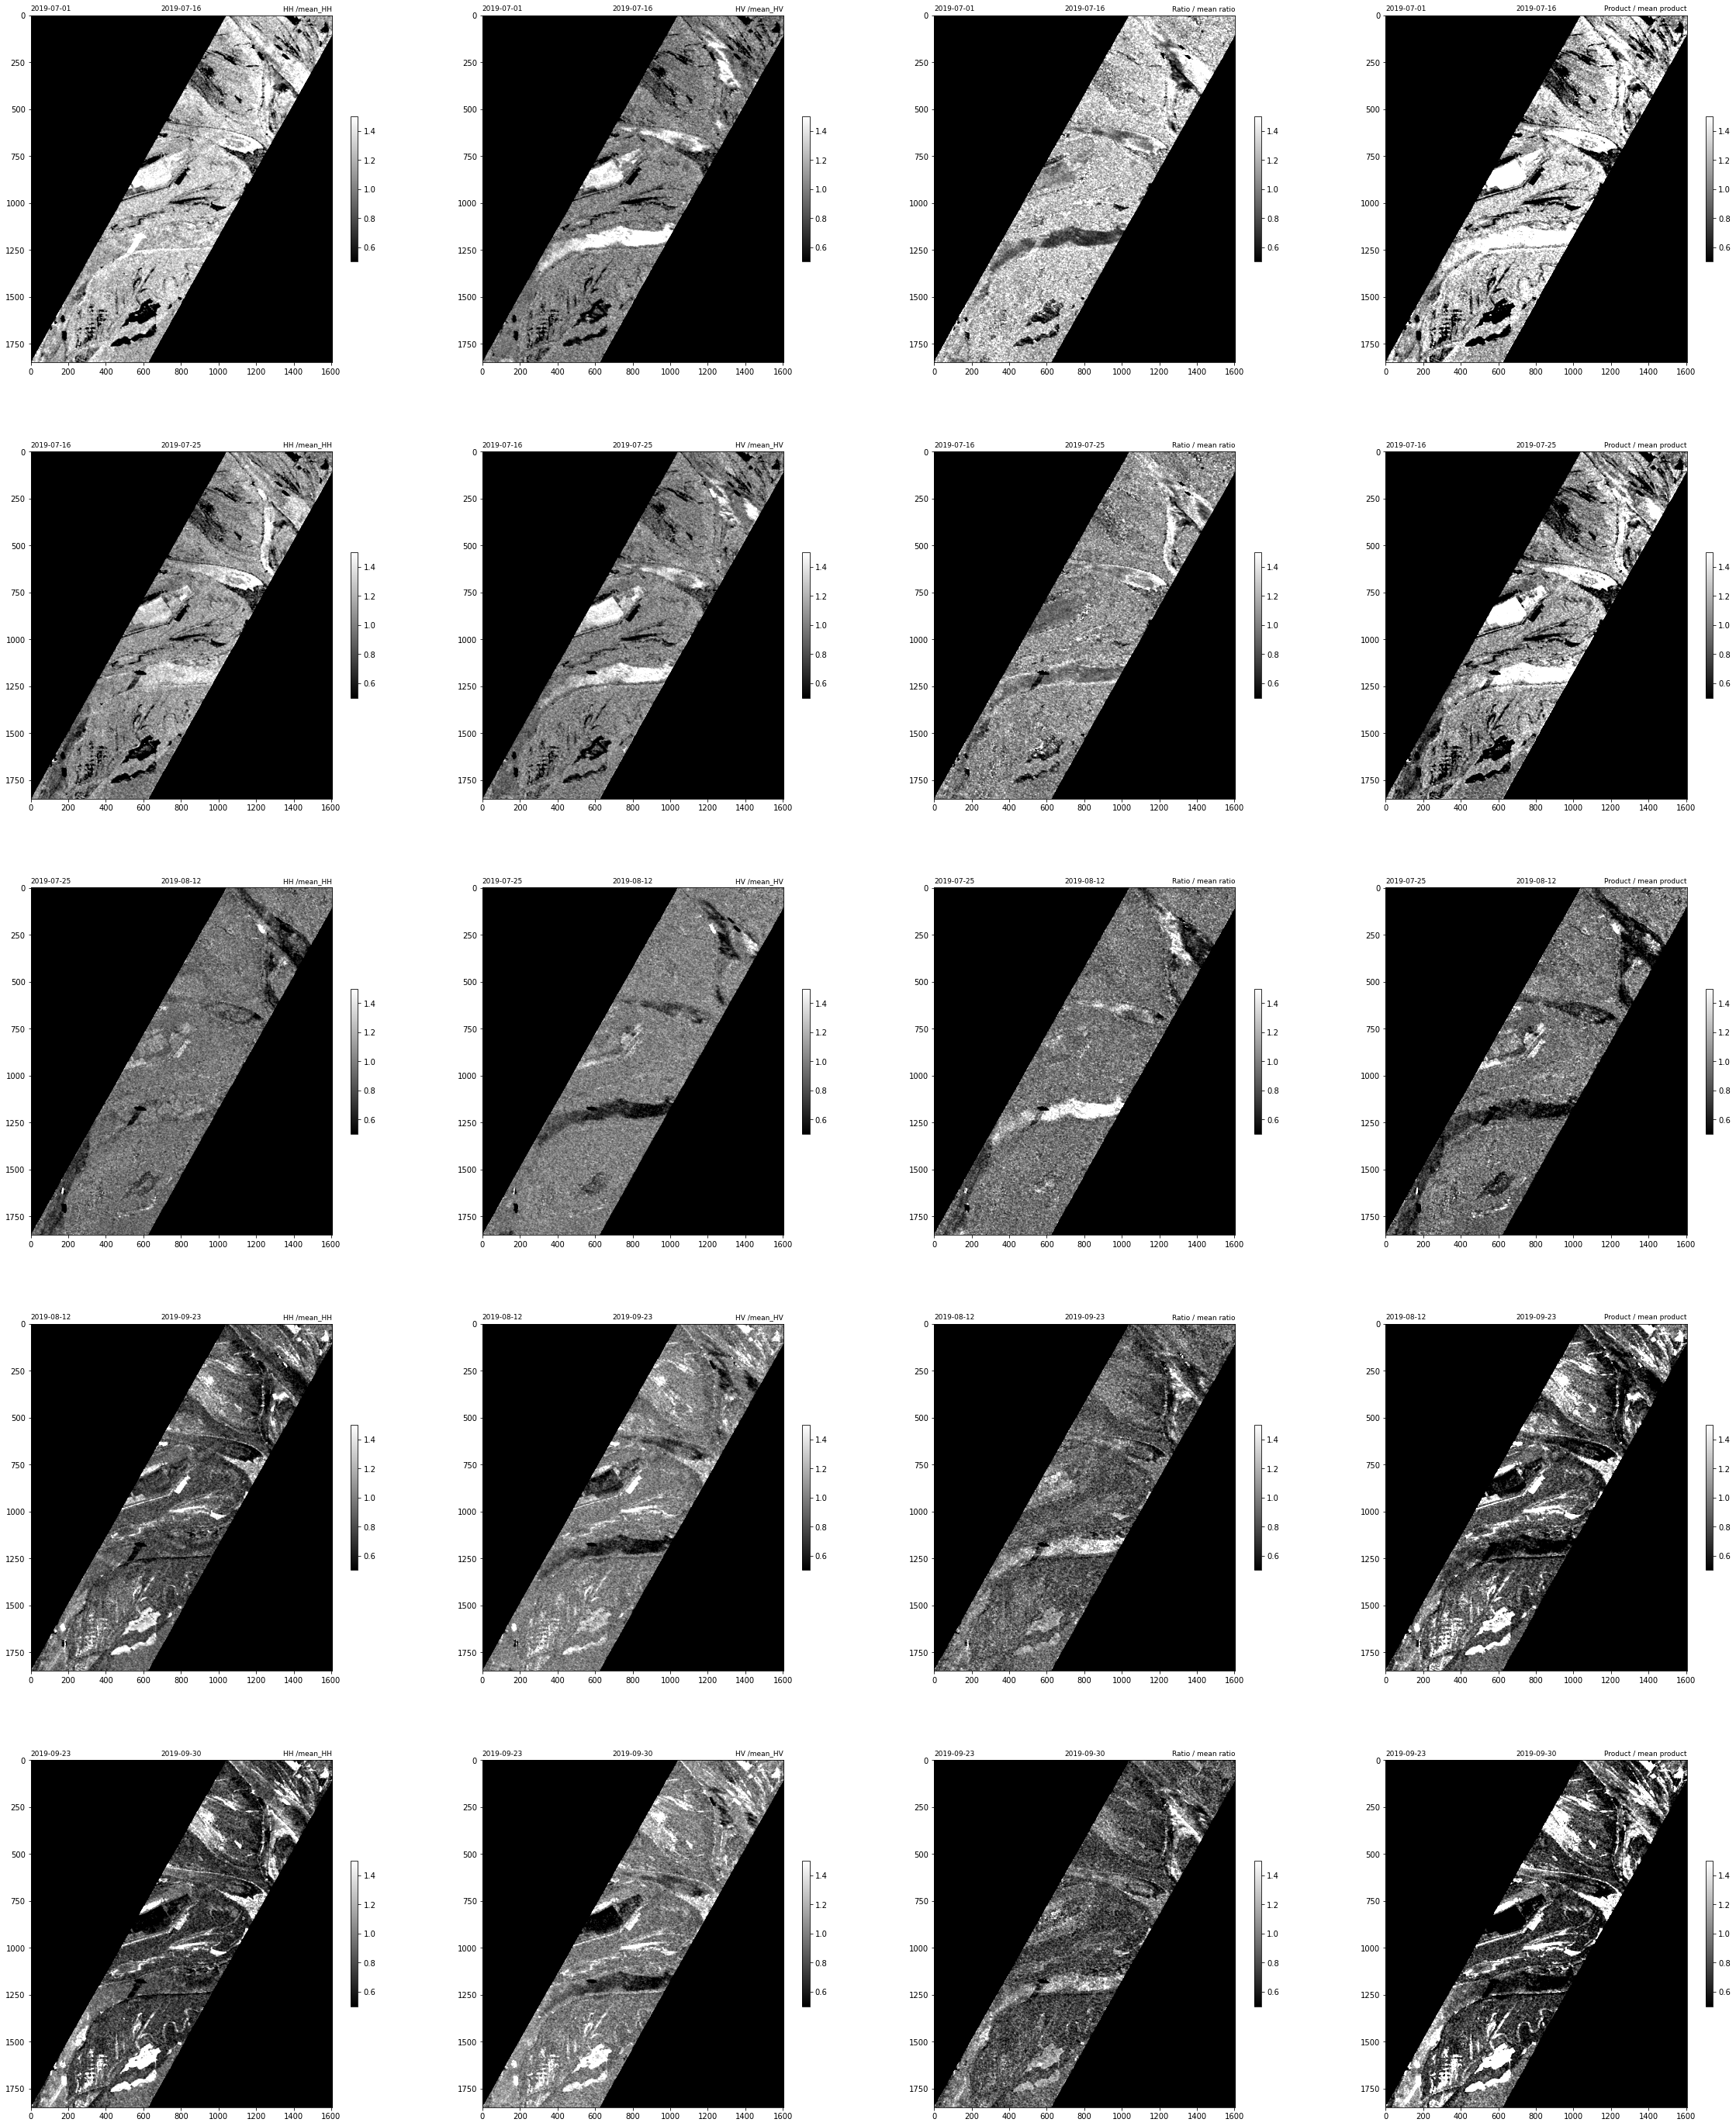

In [9]:
print("Change relative to mean values")
plt.rcParams['figure.figsize'] = (40,50)
for ii in range(Nimages):
    plt.subplot(Nimages,4,ii*4+1)
    plt.imshow(change_HH[ii,:,:],vmin=0.5,vmax=1.5,cmap=plt.cm.gray)
    plt.title(date_array[ii], loc="left",fontdict = {'fontsize' : 9})
    plt.title(date_array[ii+Nave_rolling-1], loc="center",fontdict = {'fontsize' : 9})
    plt.title("HH /mean_HH", loc="right",fontdict = {'fontsize' : 9})
    plt.colorbar(shrink=0.4)
    plt.subplot(Nimages,4,ii*4+2)
    plt.imshow(change_HV[ii,:,:],vmin=0.5,vmax=1.5,cmap=plt.cm.gray)
    plt.title(date_array[ii], loc="left",fontdict = {'fontsize' : 9})
    plt.title(date_array[ii+Nave_rolling-1], loc="center",fontdict = {'fontsize' : 9})
    plt.title("HV /mean_HV", loc="right",fontdict = {'fontsize' : 9})
    plt.colorbar(shrink=0.4)
    plt.subplot(Nimages,4,ii*4+3)
    plt.imshow(change_ratio[ii,:,:],vmin=0.5,vmax=1.5,cmap=plt.cm.gray)
    plt.title(date_array[ii], loc="left",fontdict = {'fontsize' : 9})
    plt.title(date_array[ii+Nave_rolling-1], loc="center",fontdict = {'fontsize' : 9})
    plt.title("Ratio / mean ratio", loc="right",fontdict = {'fontsize' : 9})
    plt.colorbar(shrink=0.4)
    plt.subplot(Nimages,4,ii*4+4)
    plt.imshow(change_product[ii,:,:],vmin=0.5,vmax=1.5,cmap=plt.cm.gray)
    plt.title(date_array[ii], loc="left",fontdict = {'fontsize' : 9})
    plt.title(date_array[ii+Nave_rolling-1], loc="center",fontdict = {'fontsize' : 9})
    plt.title("Product / mean product", loc="right",fontdict = {'fontsize' : 9})
    plt.colorbar(shrink=0.4)

# Classify mean image.

If the inundation state is relatively constant over the time span of the imagery, these classes may be a useful reference. However, if the inundation state is variable over the time span, this classification may be biased depending on the classification thresholds and the magnitude of the changes in backscatter.<br>
For classifying open water, HV in many cases is a more reliable indicator that HH.  However, to take advantage of both HH and HV, we find the product and threshold based on the product.<br>
For classifying inundated vegetation, typically we find that double bounce will dominate the HH backscatter and HH will be brighter than expected from the HV backscatter, which is dominated by volume scatter even in the presence of double bounce reflections occuring.  Since HH also gets brighter and darker as biomass increases or decreases, we have found HH/HV to be a valuable metric for identifying inundated vegatation, even for those cases were the double bounce contribution to HH may be smaller in herbaceous areas (for which we assign a separate class).  We therefore apply thresholds based on HH and HH/HV.

In [10]:
np.seterr(invalid='ignore')  # python doesn't like dividing zero by zero, NaN by NaN, etc.

#Thresholds to be calibrated based on other data sets:
# open water class 1
T1_prod_min =  0.000001
T1_prod_max =  .00005
# inundated veg class 16 - bright HH
T2_HH_min =  0.5
T2_HH_max =  10.
T2_ratio_min=6
T2_ratio_max=500
# inundated veg class 12  - not as bright HH in class 16, but high HH/HV ratio
T3_HH_min =  0.1
T3_HH_max =  0.3
T3_ratio_min=8
T3_ratio_max=500

classif=np.zeros(output_dim, dtype=np.int8)

#all data
classif=np.where(mean_stack_HH > 0.0,8,classif)
#open water
classif=np.where((mean_prod < T1_prod_max) & (mean_prod > T1_prod_min),3,classif)
#classify inundated veg where not classified as open water
classif=np.where((classif != 3)  & (mean_stack_HH > T2_HH_min) & (mean_stack_HH < T2_HH_max) \
                 &(mean_ratio < T2_ratio_max) & (mean_ratio > T2_ratio_min),16,classif)
classif=np.where((classif != 3)  & (mean_stack_HH > T3_HH_min) & (mean_stack_HH < T3_HH_max) \
                 &(mean_ratio < T3_ratio_max) & (mean_ratio > T3_ratio_min),12,classif)


# Display classification of mean image

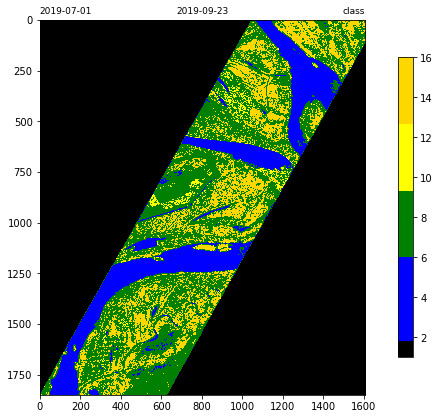

In [25]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,40)

#define color table for this and subsequent plots
colors =["black","blue","blue","blue","blue","blue",'green','green','green','green','yellow','yellow','yellow','yellow',
         'gold','gold','gold','gold']
cmap = ListedColormap(colors)

plt.subplot(Nimages,1,ii+1)
plt.imshow(classif,vmin=1,vmax=16,cmap=cmap,interpolation='none')
plt.title(date_array[0], loc="left",fontdict = {'fontsize' : 9})
plt.title(date_array[Nimages-1], loc="center",fontdict = {'fontsize' : 9})
plt.title("class", loc="right",fontdict = {'fontsize' : 9})
plt.colorbar(shrink=0.8)


# Inundation classes

The basis of the classification will be the simplest possible technique to demonstrate sensitivity to inundation state: identifying threshold values in the imagery that correspond different inundation states. A possible augmention would be to first segment the image values by pixel similarity.  

(not all values currently used)

#0 no data or not classified<br>
#1 - 5 open water<br>
#7 - 9  no surface water<br>
#11 - 13 is inundated veg due to high HH/HV <br>
#15 - 17 is inundated veg with bright HH return<br>



# Classify Time Series

In [12]:
#classify time series

#Thresholds to be calibrated based on other data sets:
# open water class 1
T1_prod_min =  0.000001
T1_prod_max =  .00005
# inundated veg class 16 - bright HH
T2_HH_min =  0.5
T2_HH_max =  10.
T2_ratio_min=6
T2_ratio_max=500
# inundated veg class 12  - not as bright HH in class 16, but has high HH/HV ratio
T3_HH_min =  0.1
T3_HH_max =  0.3
T3_ratio_min=8
T3_ratio_max=500

class_stack=np.zeros(output_stack_dim,dtype=np.int8)
change_OW=np.zeros(class_stack.shape[0],dtype=np.int32)
change_FL=np.zeros(class_stack.shape[0],dtype=np.int32)
change_NF=np.zeros(class_stack.shape[0],dtype=np.int32)

for kk in range(len(class_stack)):
    class_stack[kk,:,:]=np.where(rasterstack_rolling_corrected_HH[kk,:,:] > 0.0000001,8,class_stack[kk,:,:])

    class_stack[kk,:,:]=np.where((rasterstack_rolling_corrected_product[kk,:,:] < T1_prod_max) \
                                 & (rasterstack_rolling_corrected_product[kk,:,:] > T1_prod_min),3,class_stack[kk,:,:])

#classify inundated veg where not classified as open water
    class_stack[kk,:,:]=np.where((class_stack[kk,:,:] != 3)  \
                                 & (rasterstack_rolling_corrected_HH[kk,:,:] > T2_HH_min) \
                                 & (rasterstack_rolling_corrected_HH[kk,:,:] < T2_HH_max) \
                                 &(rasterstack_rolling_corrected_ratio[kk,:,:] < T2_ratio_max) \
                                 & (rasterstack_rolling_corrected_ratio[kk,:,:] > T2_ratio_min),16,class_stack[kk,:,:])


    class_stack[kk,:,:]=np.where((class_stack[kk,:,:] != 3)  \
                                  & (rasterstack_rolling_corrected_HH[kk,:,:] > T3_HH_min) \
                                  & (rasterstack_rolling_corrected_HH[kk,:,:] < T3_HH_max) \
                                  &(rasterstack_rolling_corrected_ratio[kk,:,:] < T3_ratio_max) \
                                  & (rasterstack_rolling_corrected_ratio[kk,:,:] > T3_ratio_min),12,class_stack[kk,:,:])

    #track changes
    change_OW[kk]=np.count_nonzero(class_stack[kk,:,:] == 3)
    
    change_FL[kk]=np.count_nonzero(class_stack[kk,:,:] == 12)+np.count_nonzero(class_stack[kk,:,:] == 16)
    
    change_NF[kk]=np.count_nonzero(class_stack[kk,:,:] == 8)

#    print(f"Number of Zeroes in Array --> {class_stack[kk,:,:][np.where( class_stack[kk,:,:]== 0)].size}")


# Display change in inundation vs time

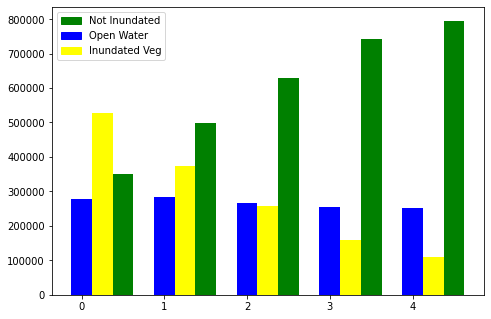

In [13]:
#sanity check
plt.rcParams['figure.figsize'] = (6,4)
fig = plt.figure()
X = np.arange(class_stack.shape[0])
ax = fig.add_axes([0,0,1,1])
classn=[0,1,2,3,4]
colors = {'Not Inundated':'green', 'Open Water':'blue','Inundated Veg':'yellow'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
#ax.legend(labels=['Not Flooded','Open Water', 'Inundated Veg'])
ax.bar(X+0.50,change_NF,color='green',width=0.25)
ax.bar(X+0.00,change_OW,color='blue',width=0.25)
ax.bar(X+0.25,change_FL,color='yellow',width=0.25)
plt.show()

# Display time sequence of classes

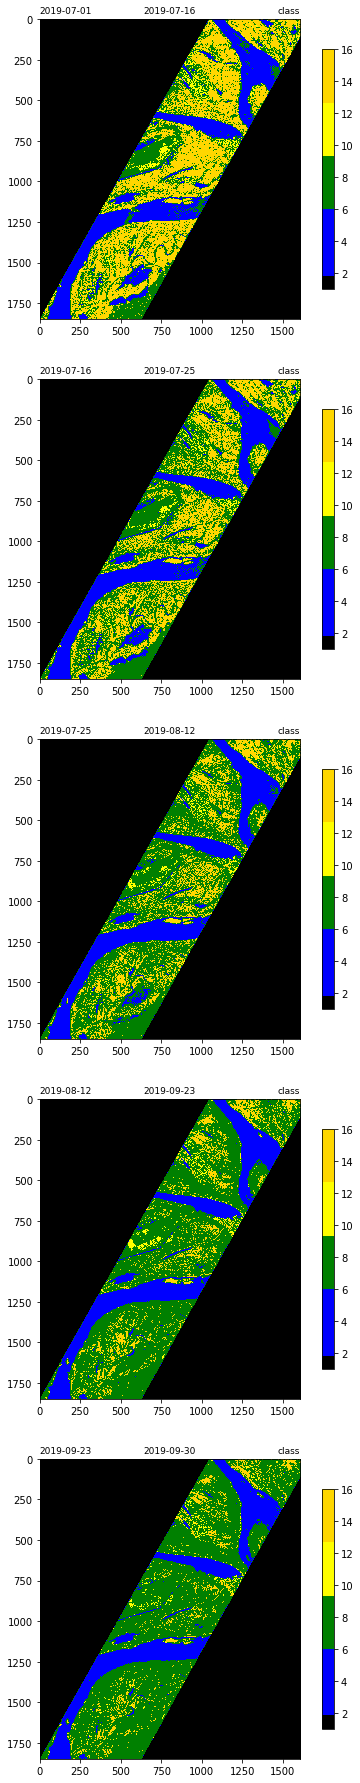

In [14]:
plt.rcParams['figure.figsize'] = (8,32)

for ii in range(Nimages):

    plt.subplot(Nimages,1,ii+1)
 
    plt.imshow(class_stack[ii,:,:],vmin=1,vmax=16,cmap=cmap,interpolation='none')
    plt.title(date_array[ii], loc="left",fontdict = {'fontsize' : 9})
    plt.title(date_array[ii+Nave_rolling-1], loc="center",fontdict = {'fontsize' : 9})
    plt.title("class", loc="right",fontdict = {'fontsize' : 9})
    plt.colorbar(shrink=0.8)



# Examine change relative to means for each time stamp to refine classes

Change in HH backscatter and in HH/HV from the mean or the previous HH and HH/HV values can be a more robust indicator of a change occuring in class. Thresholds are applied based on those change metrics.

Not yet implemented option: change focused on changes from typical inundation state derived from the mean imagery over the entire time span. Detect change in backscatter for each time stamp within identified classes from mean imagery to refine classes. This will be an augmentation to the change detection implemented below for all areas and is TBD.

In [15]:
change_OW_2=np.zeros(class_stack.shape[0],dtype=np.int32)
change_FL_2=np.zeros(class_stack.shape[0],dtype=np.int32)
change_NF_2=np.zeros(class_stack.shape[0],dtype=np.int32)

T5_HH_inc=2
T5_HH_dec=0.5
T5_ratio_inc=2
T5_ratio_dec=0.5

T6_HH_inc=2
T6_HH_dec=0.5
T6_ratio_inc=2
T6_ratio_dec=0.5

T7_HH_inc=4
T7_HH_dec=0.25
T7_ratio_inc=4
T7_ratio_dec=0.25

for kk in range(Nimages):

#open water increased by x, -> no surface water
    class_stack[kk,:,:]=np.where((class_stack[kk,:,:] == 3)  \
                                 & (change_HH[kk,:,:] > T5_HH_inc) \
                                 & (change_ratio[kk,:,:] < T5_ratio_inc),7,class_stack[kk,:,:])
    class_stack[kk,:,:]=np.where((class_stack[kk,:,:] == 3)  \
                                 & (change_HH[kk,:,:] > T5_HH_inc) \
                                 & (rasterstack_rolling_corrected_ratio[kk,:,:] > T3_ratio_max),11,class_stack[kk,:,:])
    
#inundated veg decreased by x, -> no surface water
    class_stack[kk,:,:]=np.where((class_stack[kk,:,:] == 16)  \
                                 & (change_HH[kk,:,:] < T6_HH_dec) \
                                 & (change_ratio[kk,:,:] < T6_ratio_dec),9,class_stack[kk,:,:])
    class_stack[kk,:,:]=np.where((class_stack[kk,:,:] == 12)  \
                                 & (change_HH[kk,:,:] < T6_HH_dec) \
                                 & (change_ratio[kk,:,:] < T6_ratio_dec),9,class_stack[kk,:,:])
     
#no surface water decreased by x, -> open water
    class_stack[kk,:,:]=np.where((class_stack[kk,:,:] == 8)  \
                                 & (change_HH[kk,:,:] < T5_HH_dec) \
                                 & (change_ratio[kk,:,:] > T5_ratio_inc),4,class_stack[kk,:,:])
#no surface water increased by x, -> inundated veg
    class_stack[kk,:,:]=np.where((class_stack[kk,:,:] == 8)  \
                                 & (change_HH[kk,:,:] > T6_HH_inc) \
                                 & (change_ratio[kk,:,:] > T6_ratio_inc),13,class_stack[kk,:,:])

#track changes
    change_OW_2[kk]=np.count_nonzero(class_stack[kk,:,:] == 1)+np.count_nonzero(class_stack[kk,:,:] == 2)\
    +np.count_nonzero(class_stack[kk,:,:] == 3)+np.count_nonzero(class_stack[kk,:,:] == 4)\
    +np.count_nonzero(class_stack[kk,:,:] == 5)

    change_FL_2[kk]=np.count_nonzero(class_stack[kk,:,:] == 11)+np.count_nonzero(class_stack[kk,:,:] == 12)\
    +np.count_nonzero(class_stack[kk,:,:] == 13)\
    +np.count_nonzero(class_stack[kk,:,:] == 15)\
    +np.count_nonzero(class_stack[kk,:,:] == 16)\
    +np.count_nonzero(class_stack[kk,:,:] == 17)\
    
    change_NF_2[kk]=np.count_nonzero(class_stack[kk,:,:] == 7)+np.count_nonzero(class_stack[kk,:,:] == 8)\
    +np.count_nonzero(class_stack[kk,:,:] == 9)
    



# To assess impact of change detection to classification results, plot the change in number of pixels in each class for each time period.

Change in surface water classes


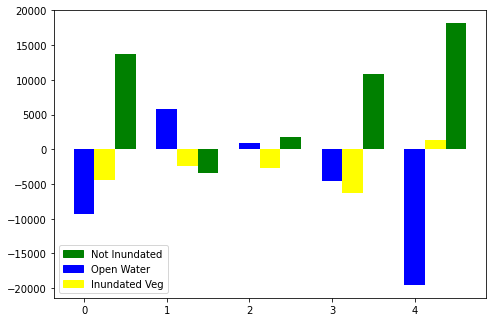

In [16]:
#display change in inundation vs time

print("Change in surface water classes")
plt.rcParams['figure.figsize'] = (6,4)
fig = plt.figure()
X = np.arange(class_stack.shape[0])
ax = fig.add_axes([0,0,1,1])
classn=[0,1,2,3,4]
colors = {'Not Inundated':'green', 'Open Water':'blue','Inundated Veg':'yellow'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
ax.bar(X+0.50,100*(change_NF_2-change_NF),color='green',width=0.25)
ax.bar(X+0.00,100*(change_OW_2-change_OW),color='blue',width=0.25)
ax.bar(X+0.25,100*(change_FL_2-change_FL),color='yellow',width=0.25)

plt.show()

# Display final time sequence of wetland inundation classes

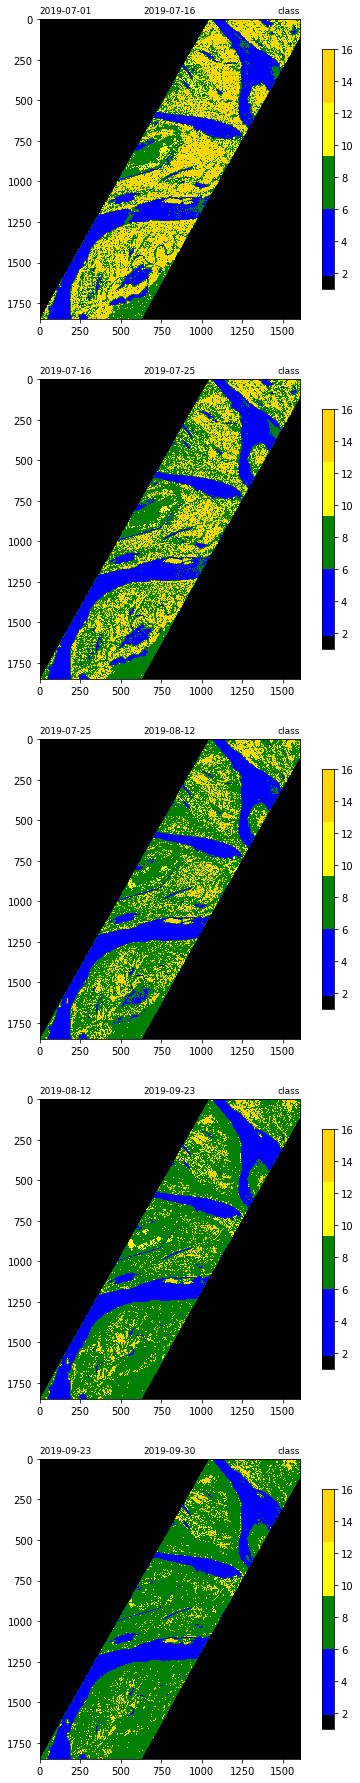

In [17]:
plt.rcParams['figure.figsize'] = (8,32)

for ii in range(Nimages):

    plt.subplot(Nimages,1,ii+1)
    plt.imshow(class_stack[ii,:,:],vmin=1,vmax=16,cmap=cmap,interpolation='none')
    plt.title(date_array[ii], loc="left",fontdict = {'fontsize' : 9})
    plt.title(date_array[ii+Nave_rolling-1], loc="center",fontdict = {'fontsize' : 9})
    plt.title("class", loc="right",fontdict = {'fontsize' : 9})
    plt.colorbar(shrink=0.8)
    plt.savefig('Example_final_classes.png')

# Output binary Results for each time period

In [18]:
#output results
os.chdir(Output_folder)
for kk in range(len(class_stack)):
    outname = os.path.join(Output_folder,date_array[kk].strftime("%m_%d_%Y"))
    outname = outname + '_class.bin'
    fid = open(outname,'wb')
    print(kk,outname)
    tmp = np.byte(np.copy(class_stack[kk,:,:]))
    fid.write(tmp)
    fid.close();
os.chdir(main_dir)

0 /home/jovyan/ATBD dev/Notebook_outputs/07_01_2019_class.bin
1 /home/jovyan/ATBD dev/Notebook_outputs/07_16_2019_class.bin
2 /home/jovyan/ATBD dev/Notebook_outputs/07_25_2019_class.bin
3 /home/jovyan/ATBD dev/Notebook_outputs/08_12_2019_class.bin
4 /home/jovyan/ATBD dev/Notebook_outputs/09_23_2019_class.bin


# Plot the area of each class within the imagery for each time period

Change in area of surface water classes over time


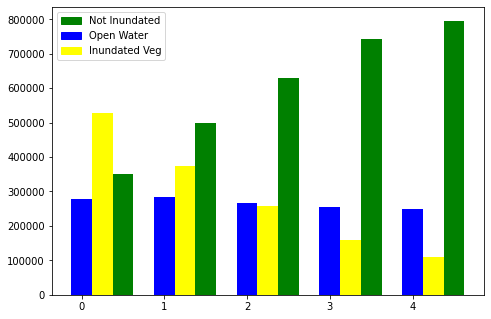

In [19]:
#display change in inundation vs time

print("Change in area of surface water classes over time")
plt.rcParams['figure.figsize'] = (6,4)
fig = plt.figure()
X = np.arange(class_stack.shape[0])
ax = fig.add_axes([0,0,1,1])
classn=[0,1,2,3,4]
colors = {'Not Inundated':'green', 'Open Water':'blue','Inundated Veg':'yellow'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
ax.bar(X+0.50,change_NF_2,color='green',width=0.25)
ax.bar(X+0.00,change_OW_2,color='blue',width=0.25)
ax.bar(X+0.25,change_FL_2,color='yellow',width=0.25)
plt.savefig('Example_AreaChange.png')
plt.show()



# Water level gage data at nearby Vicksburg Bridge on the Mississippi River
(water level does not generally correspond linearly to surface water extent)

<img style="float: left;" src="water_level_chart1.png">

https://rivergages.mvr.usace.army.mil/WaterControl/stationinfo2.cfm?sid=CE40FF58&fid=VCKM6&dt=S